In [1]:
%matplotlib inline
from keras.layers import Lambda, Input, Dense, Concatenate
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import regularizers
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance
import argparse
import seaborn as sns
import os
import itertools
import umap
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import networkx as nx
import json
from collections import Counter, defaultdict
from sklearn.metrics import f1_score
from pylab import rcParams
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
from tqdm import tqdm
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
np.random.seed(0)

# Create example data

In [4]:
def generate_aja_nonbipartite(node_size, density):
    edge_size = int(node_size * (node_size-1) / 2 * density)
    ajc = nx.adjacency_matrix(
        nx.generators.dense_gnm_random_graph(node_size,edge_size), weight=None
    ).A
    
    return ajc

def generate_aja_bipartite(n_users, n_features, density):
    subblock_edge_size = int(n_users * n_features * density)
    temp_G = nx.bipartite.gnmk_random_graph(n_users, n_features, subblock_edge_size)
    top_nodes = [n for n, d in temp_G.nodes(data=True) if d['bipartite'] == 0]
    bottom_nodes = list(set(temp_G) - set(top_nodes))
    
    ajc = nx.bipartite.biadjacency_matrix(
        temp_G, row_order=top_nodes,column_order=bottom_nodes
    ).A
    
    return ajc

In [5]:
example_density = 74459 / ((7298 * (7298 - 1)) / 2) # same density as original data in the paper
example_node_size = 7298 # same number of users as original data in the paper
example_attribute_size = 3047 # same number of attrobutes as original data in the paper

In [7]:
example_ajacency = generate_aja_nonbipartite(example_node_size, example_density).astype(np.float64)
example_attribute = generate_aja_bipartite(example_node_size, example_attribute_size, example_density).astype(np.float64)

In [ ]:
example_user_names = np.array(list(map(lambda x: 'user_' + str(x), list(range(example_node_size)))))
example_attribute_names = np.array(list(map(lambda x: '#attr_' + str(x), list(range(example_attribute_size)))))

In [50]:
np.save('datasets/ajacency_example.npy', example_ajacency)

np.save('datasets/attribute_example.npy', example_attribute)

np.save('datasets/attribute_name_example.npy', example_attribute_names)

np.save('datasets/username_list_example.npy', example_user_names)

# Load data

In [8]:
ajacency = np.load('datasets/ajacency_example.npy').astype(np.float64)

attribute = np.load('datasets/attribute_example.npy').astype(np.float64)

attribute_names = np.load('datasets/attribute_name_example.npy')

user_names = np.load('datasets/username_list_example.npy')

In [9]:
mixed = np.concatenate((ajacency, attribute), 1)
input_shape = mixed.shape[1]
input_size = mixed.shape[0]

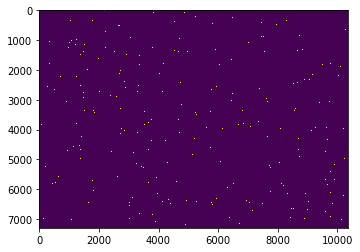

In [10]:
plt.imshow(mixed)

In [27]:
np.float64

numpy.float64

In [26]:
ajacency.dtype

dtype('int32')

# Utils

In [11]:
class StreamingMovingAverage:
    def __init__(self, window_size):
        self.window_size = window_size
        self.values = []
        self.sum = 0

    def process(self, value):
        self.values.append(value)
        self.sum += value
        if len(self.values) > self.window_size:
            self.sum -= self.values.pop(0)
        return float(self.sum) / len(self.values)

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# Add artificial dense blocks

In [12]:
def generate_dense_block_ajacency(node_size, density):
    edge_size = int(node_size * (node_size-1) / 2 * density)
    return nx.adjacency_matrix(
        nx.generators.dense_gnm_random_graph(node_size,edge_size), weight=None
    ).A

def generate_dense_block_attribute(attr, k, lam, add_k_laplace, density):
    n_users = attr.shape[0]
    n_features = attr.shape[1]
    subblock_edge_size = int(n_users * k * density)

    num = np.exp(lam * (np.sum(attr, axis=0) + add_k_laplace))
    num = np.asarray([min(i, 10000) for i in num])
    prob_distri = num / (np.sum(num))
    attr_idx = np.arange(n_features)
    
    indices = np.random.choice(attr_idx,
                                   size=k,
                                   p=prob_distri,replace=False)
    
    temp_G = nx.bipartite.gnmk_random_graph(n_users, k, subblock_edge_size)
    top_nodes = [n for n, d in temp_G.nodes(data=True) if d['bipartite'] == 0]
    bottom_nodes = list(set(temp_G) - set(top_nodes))
    
    ajc = nx.bipartite.biadjacency_matrix(
        temp_G, row_order=top_nodes,column_order=bottom_nodes
    ).A
    
    return ajc, indices

In [13]:
tracking_artificial_anomaly = np.zeros(input_size)
tracking_artificial_anomaly_aggregate = []

In [14]:
synthetic_density = .1

In [15]:
blocks = [
    {'idx_range':(1000, 1500), 'ajacency_density':synthetic_density, 'attribute_k': 100, 'attribute_lambda': 1, 'add_k_laplace': 10, 'attribute_density':synthetic_density},
    {'idx_range':(3000, 3500), 'ajacency_density':synthetic_density, 'attribute_k': 100, 'attribute_lambda': 1, 'add_k_laplace': 10, 'attribute_density':synthetic_density},
    {'idx_range':(5000, 5500), 'ajacency_density':synthetic_density, 'attribute_k': 100, 'attribute_lambda': 1, 'add_k_laplace': 10, 'attribute_density':synthetic_density}
]


In [16]:
for ind, b in enumerate(blocks):
    s_idx = b['idx_range'][0]
    e_idx = b['idx_range'][1]
    ajacency[s_idx:e_idx,s_idx:e_idx] = generate_dense_block_ajacency(e_idx - s_idx, b['ajacency_density'])
    sub_attr_block, indices = generate_dense_block_attribute(attribute[s_idx:e_idx,:], 
        b['attribute_k'], b['attribute_lambda'], b['add_k_laplace'], b['attribute_density'])
    attribute[s_idx:e_idx,:][:,indices] = sub_attr_block
    
    tracking_artificial_anomaly[s_idx:e_idx] = ind + 1
    for i in range(s_idx, e_idx):
        tracking_artificial_anomaly_aggregate.append(i)

In [17]:
tracking_is_anomaly = (tracking_artificial_anomaly != 0).astype(int)

print(np.sum(tracking_is_anomaly))

1500


# Set configuration for Hashtag Fngerprint

In [18]:
hashtag_visual_size = 60 # number of popular hashtags to visualize in Hashtag Fingerprint
hashtag_visual_idx = np.argsort(np.sum(attribute,axis=0))[::-1][:hashtag_visual_size]

# Merge data

In [19]:
mixed = np.concatenate((ajacency, attribute), 1)
input_shape = mixed.shape[1]
input_size = mixed.shape[0]
input_shape_ajacency = ajacency.shape[1]
input_shape_attribute = attribute.shape[1]

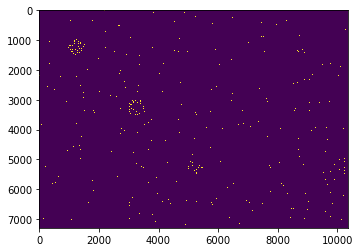

In [20]:
plt.imshow(mixed)

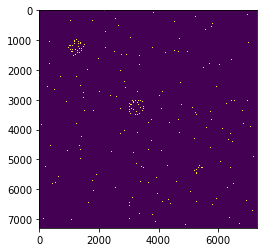

In [21]:
plt.imshow(ajacency)

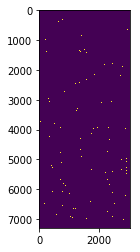

In [22]:
plt.imshow(attribute)

In [23]:
np.save(open('synthetic_datasets/ajacency_injected_example.npy','wb'), ajacency.astype(np.float64))

np.save(open('synthetic_datasets/attribute_injected_example.npy','wb'), attribute.astype(np.float64))

np.save(open('synthetic_datasets/is_anomaly_injected_example.npy','wb'), tracking_is_anomaly)

# Calculate metrics (only works with CUDA GPU)

In [31]:
from numba import cuda
from numba import vectorize, float64, int64

USE_64 = True

if USE_64:
    bits = 64
    np_type = np.float64
else:
    bits = 32
    np_type = np.float32

@cuda.jit("void(float{}[:, :], float{}[:, :])".format(bits, bits))
def distance_matrix(mat, out):
    m = mat.shape[0]
    n = mat.shape[1]
    i, j = cuda.grid(2)
    d = 0
    if i < m and j < m:
        for k in range(n):
            tmp = mat[i, k] - mat[j, k]
            d += tmp * tmp
        out[i, j] = d

def gpu_dist_matrix(mat):
    rows = mat.shape[0]

    block_dim = (16, 16)
    grid_dim = (int(rows/block_dim[0] + 1), int(rows/block_dim[1] + 1))

    stream = cuda.stream()
    mat2 = cuda.to_device(np.asarray(mat, dtype=np_type), stream=stream)
    out2 = cuda.device_array((rows, rows))
    distance_matrix[grid_dim, block_dim](mat2, out2)
    out = out2.copy_to_host(stream=stream)
    return out

@vectorize([float64(float64, float64, int64)],target='cuda')
def create_metric(manhatten, dot_prod, input_input_shape):
    if manhatten == 0:
        return (dot_prod + input_input_shape - 1) / (dot_prod + input_input_shape)
    elif dot_prod == 0:
        return 1 / (manhatten + input_input_shape)
    else:
        return dot_prod / (dot_prod + manhatten)

In [32]:
ajacency = ajacency.astype(np.float64)
attribute = attribute.astype(np.float64)

pairwise_manhatten_ajacency = gpu_dist_matrix(ajacency)
pairwise_manhatten_attribute = gpu_dist_matrix(attribute)

pairwise_dot_ajacency = ajacency.dot(ajacency.T)
pairwise_dot_attribute = attribute.dot(attribute.T)

pairwise_similarity_metric_ajacency = create_metric(pairwise_manhatten_ajacency,pairwise_dot_ajacency,input_shape_ajacency)
pairwise_similarity_metric_attribute = create_metric(pairwise_manhatten_attribute,pairwise_dot_attribute,input_shape_attribute)

# Joint autoencoder

### Meta parameters

In [33]:
small_cluster_threshold = 1000000 # the largest cluster to visualize (avoiding computation for large clsuter visualization)
num_choices = 0 # number of hyperparameter choices for random search process
density_threshold = .03 # network density threshold for identify anomalous clusters

use_best_hyper_opt = True # whether to use the best hyperparameter (setting to False leads to random search for hyperparameter)

### Best hyperparameter

In [34]:
# Best hyperparameter found using random search with synthetic data:
# synthetic performance for injected network density 0.1: F-measure: ~0.97

best_hyper_opt = (
    20, # adjacency matrix encoder latent dimension
    
    100, # attribute matrix encoder latent dimension
    
    5, # joint embedding matrix encoder latent dimension
    
    30, # number of samples (nodes) to use in a batch for updating the joint autoencoder
    
    5000, # number of epochs of training
    
    (0.1, 0.9), # (adjacency weight, attribute weight) or (w_A, w_X) in the paper
    
    (0.9, 0.1), # (reconstruction weight, similarity weight) or (w_recon, w_sim) in the paper
    
    10, # attention surplus to control for attention weight in order to focus on non-zero entries 
        # in attribute and adjacency matrix
    
    10, # temperature to use in logit transformation of Euclidean distance range to Jaccard distance range,
        # higher temperature leads to sharper transformation. To understand intuitively, try the following code:
        
        # for temperature in [0.01, 0.1,1,10,100]:
            # plt.plot(np.e**(-1 * temperature *np.array(list(range(100)))))
            # plt.show()
    
    10, # temperature to use for exponential transformation of joint pairwise similarity (weighted by w_A, w_X) 
        # between two users. For each node in the training batch, the transformed value determine likelihood of 
        # other nodes being sampled to update the joint autoencoder. Tuning this value can lead to sampling uniformly
        # at random, sampling nodes similar to the current node, or dissimilar to the current node. Similarly, higher
        # temperature leads to sharper transformation
    
    1e-08 # L2 regularization weight for all layers of joint autoencoder
)

### Random search for best hyperparameter

In [35]:
# ######################### hyperparam set #############################
# nn structure
encoding_dim_ajacency = [20, 100]
encoding_dim_attribute = [20, 100]
encoding_dim_joint = [5, 10]

# training details
num_sample = [5, 10, 30]
epochs = [5000, 20000]

# weight params aja/attr
ajacency_weight = [0, .1, .5, .9, 1]
attribute_weight = (1-np.array(ajacency_weight)).tolist()
ajacency_attribute_weight = list(zip(ajacency_weight, attribute_weight))

# weight params recon/sim
reconstruction_weight = [0, .1, .5, .9, 1]
similarity_weight = (1 - np.array(reconstruction_weight)).tolist()
reconstruction_similarity_weight = list(zip(reconstruction_weight, similarity_weight))

# attention and temperature
input_attention_surplus = [1, 10, 100]
estimated_similarity_lambda = [-10, -1, -.1, .1, 1, 10]
sample_logit_temperature = [-10, -1, -.1, 0, .1, 1, 10]

# regularization
regularization_weight = [1e-5, 1e-8]

######################################################

hyperparam_options = []

for element in itertools.product(
    encoding_dim_ajacency,encoding_dim_attribute,encoding_dim_joint,num_sample,epochs,
    ajacency_attribute_weight,reconstruction_similarity_weight,
    input_attention_surplus,estimated_similarity_lambda,sample_logit_temperature,regularization_weight
):
    hyperparam_options.append(element)

hyperparam_idx = list(range(len(hyperparam_options)))
hyperparam_idx = np.random.choice(hyperparam_idx, num_choices, replace=False).astype(int)

hyperparam_choices = [hyperparam_options[idx] for idx in hyperparam_idx]


if use_best_hyper_opt:
    hyperparam_choices = [
        best_hyper_opt,
    ]

### Running experiment on synthetic data

In [36]:
fmeasure_list = []

for run_ind, opt in enumerate(hyperparam_choices):

    print('='*100, ' #{}'.format(run_ind))
    temp_info = {
        'encoding_dim_ajacency':opt[0], 'encoding_dim_attribute':opt[1], 'encoding_dim_joint':opt[2],
        'num_sample':opt[3], 'epochs':opt[4], 'ajacency_attribute_weight':opt[5],
        'reconstruction_similarity_weight':opt[6],
        'input_attention_surplus':opt[7], 'estimated_similarity_lambda':opt[8],
        'sample_logit_temperature':opt[9], 'regularization_weight':opt[10]
    }
    print(temp_info)

    ######################### hyperparam set #############################
    # nn structure
    encoding_dim_ajacency = opt[0]
    encoding_dim_attribute = opt[1]
    encoding_dim_joint = opt[2]

    # training details
    num_sample = opt[3]
    epochs = opt[4]

    # weight params aja/attr
    ajacency_weight, attribute_weight = opt[5]

    # weight params recon/sim
    reconstruction_weight, similarity_weight = opt[6]

    # attention and temperature
    input_attention_surplus = opt[7]
    estimated_similarity_lambda = opt[8]
    sample_logit_temperature = opt[9]

    # regularization
    regularization_weight = opt[10]

    ############################ basic scaffolding #############################

    idx_list = list(range(input_size))
    averger_online = StreamingMovingAverage(400)

    pairwise_similarity_metric = ajacency_weight * pairwise_similarity_metric_ajacency + \
        attribute_weight * pairwise_similarity_metric_attribute

    ############################ neural scaffolding #############################

    input_vec_ajacency = Input(shape=(input_shape_ajacency,),name='input_vec_ajacency')
    input_vec_attribute = Input(shape=(input_shape_attribute,),name='input_vec_attribute')
    encoded_ajacency = Dense(encoding_dim_ajacency, activation='relu',
                    activity_regularizer=regularizers.l2(regularization_weight),name='encoded_ajacency')(input_vec_ajacency)
    encoded_attribute = Dense(encoding_dim_attribute, activation='relu',
                    activity_regularizer=regularizers.l2(regularization_weight),name='encoded_attribute')(input_vec_attribute)
    encoded_concat = Concatenate(axis=-1,name='encoded_concat')([encoded_ajacency,encoded_attribute])
    encoded_joint = Dense(encoding_dim_joint, activation='relu',
                    activity_regularizer=regularizers.l2(regularization_weight),name='encoded_joint')(encoded_concat)

    decoded_ajacency = Dense(input_shape_ajacency, activation='relu',
                    activity_regularizer=regularizers.l2(regularization_weight),name='decoded_ajacency')(encoded_joint)
    decoded_attribute = Dense(input_shape_attribute, activation='relu',
                    activity_regularizer=regularizers.l2(regularization_weight),name='decoded_attribute')(encoded_joint)

    encoder_ajacency = Model(input_vec_ajacency,encoded_ajacency,name='encoder_ajacency')
    encoder_attribute = Model(input_vec_attribute,encoded_attribute,name='encoder_attribute')
    encoder_joint = Model([input_vec_ajacency,input_vec_attribute],encoded_joint,name='encoder_joint')

    sample_vecs_ajacency = Input(shape=(num_sample, input_shape_ajacency),name='sample_vecs_ajacency')
    sample_similarity_score_ajacency = Input(shape=(num_sample,),name='sample_similarity_score_ajacency')

    sample_vecs_attribute = Input(shape=(num_sample, input_shape_attribute),name='sample_vecs_attribute')
    sample_similarity_score_attribute = Input(shape=(num_sample,),name='sample_similarity_score_attribute')

    sample_similarity_score_joint = Input(shape=(num_sample,),name='sample_similarity_score_joint')

    ############################ loss #############################

    def mixed_loss(encoder_ajacency, decoder_ajacency, encoder_attribute, decoder_attribute, encoder_joint,
                   input_vec_ajacency, sample_vecs_ajacency, input_vec_attribute, sample_vecs_attribute, 
                   ajacency_weight, attribute_weight, sample_similarity_score_ajacency,
                   sample_similarity_score_attribute, sample_similarity_score_joint, reconstruction_weight,
                   similarity_weight,input_attention_surplus,estimated_similarity_lambda):

        def reconstruction_loss_helper(y_true,y_pred):
            return K.sum(K.square(
                (y_true - y_pred) * (K.ones_like(y_true) + \
                    input_attention_surplus * y_true)
            ))

        def reconstruction_loss():
            temp_encoded_joint = encoder_joint([input_vec_ajacency,input_vec_attribute])

            ajacency_reconstruction_loss = reconstruction_loss_helper(
                input_vec_ajacency,decoder_ajacency(temp_encoded_joint))

            attribute_reconstruction_loss = reconstruction_loss_helper(
                input_vec_attribute,decoder_attribute(temp_encoded_joint))

            return ajacency_weight * ajacency_reconstruction_loss + attribute_weight * attribute_reconstruction_loss

        def similarity_loss_helper(y_input,y_sample_inputs,y_sample_similarity_scores,encoder):
            sample_loss = K.square(
                    K.exp(
                        -estimated_similarity_lambda * K.sum(
                            K.square(encoder(y_input) - encoder(y_sample_inputs)), axis=-1
                        )
                    ) - y_sample_similarity_scores
                )

            sample_loss_aggregate = K.sum(K.dot(y_sample_similarity_scores, K.transpose(sample_loss)))

            return sample_loss_aggregate

        def similarity_loss():
            joint_similarity_loss = similarity_loss_helper(
                [input_vec_ajacency,input_vec_attribute],
                [sample_vecs_ajacency,sample_vecs_attribute],
                sample_similarity_score_joint,encoder_joint)
            return joint_similarity_loss

        def regularization_loss():
            return 0

        def mixed_loss_helper(*args,**kwargs):
            return reconstruction_weight/input_size * reconstruction_loss() + similarity_weight * similarity_loss() + \
                regularization_weight * regularization_loss()

        return mixed_loss_helper

    ############################ compile model #############################

    autoencoder = Model(inputs = [input_vec_ajacency, sample_vecs_ajacency, sample_similarity_score_ajacency,
                                  input_vec_attribute, sample_vecs_attribute, sample_similarity_score_attribute,
                                  sample_similarity_score_joint],
                       outputs = [decoded_ajacency, decoded_attribute],name='autoencoder')

    encoded_joint_input = Input(shape=(encoding_dim_joint,),name='encoded_joint_input')

    decoder_layer_ajacency = autoencoder.get_layer('decoded_ajacency')
    decoder_layer_attribute = autoencoder.get_layer('decoded_attribute')

    decoder_ajacency = Model(encoded_joint_input, decoder_layer_ajacency(encoded_joint_input),name='decoder_ajacency')
    decoder_attribute = Model(encoded_joint_input, decoder_layer_attribute(encoded_joint_input),name='decoder_attribute')

    autoencoder.compile(optimizer='adadelta', 
                        loss = mixed_loss(encoder_ajacency, decoder_ajacency, encoder_attribute, decoder_attribute, encoder_joint,
                           input_vec_ajacency, sample_vecs_ajacency, input_vec_attribute, sample_vecs_attribute, 
                           ajacency_weight, attribute_weight, sample_similarity_score_ajacency,
                           sample_similarity_score_attribute, sample_similarity_score_joint, reconstruction_weight,
                           similarity_weight,input_attention_surplus,estimated_similarity_lambda)
                       )

    ############################ train #####################################

    for cnt in range(epochs):
        idx = np.random.randint(0, input_size)
        base_dist = pairwise_similarity_metric[idx]
        sample_dist = np.exp(sample_logit_temperature * base_dist)
        sample_dist[idx] = 0
        sample_dist = sample_dist / np.sum(sample_dist)
        sample_idx = np.random.choice(idx_list, size=num_sample, replace=False, p=sample_dist)

        input_input_vec_ajacency = ajacency[idx:idx+1]
        input_input_vec_attribute = attribute[idx:idx+1]
        input_sample_vecs_ajacency = np.expand_dims(ajacency[sample_idx,:], axis=0)
        input_sample_vecs_attribute = np.expand_dims(attribute[sample_idx,:], axis=0)
        input_sample_similarity_score_ajacency = np.expand_dims(pairwise_similarity_metric_ajacency[idx,sample_idx], axis=0)
        input_sample_similarity_score_attribute = np.expand_dims(pairwise_similarity_metric_attribute[idx,sample_idx], axis=0)
        input_sample_similarity_score_joint = np.expand_dims(pairwise_similarity_metric[idx,sample_idx], axis=0)

        loss_all = autoencoder.train_on_batch(
            [input_input_vec_ajacency, input_sample_vecs_ajacency,input_sample_similarity_score_ajacency,
                input_input_vec_attribute, input_sample_vecs_attribute,input_sample_similarity_score_attribute,
                input_sample_similarity_score_joint], 
            [input_input_vec_ajacency, input_input_vec_attribute]
        )

        loss = loss_all[0]

        if cnt % 4999 == 1:
            print("Iteration {}, loss={}".format(cnt, averger_online.process(loss)))
        else:
            averger_online.process(loss)

====================================================================================================  #0
{'encoding_dim_ajacency': 20, 'encoding_dim_attribute': 100, 'encoding_dim_joint': 5, 'num_sample': 30, 'epochs': 5000, 'ajacency_attribute_weight': (0.1, 0.9), 'reconstruction_similarity_weight': (0.9, 0.1), 'input_attention_surplus': 10, 'estimated_similarity_lambda': 10, 'sample_logit_temperature': 10, 'regularization_weight': 1e-08}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Iteration 1, loss=0.3236922025680542


### Create embedding for clustering and visualization

In [37]:
encoded_vecs = encoder_joint.predict([ajacency,attribute])
X_embedded = umap.UMAP().fit_transform(encoded_vecs)

# Clustering and visualization

visualize embedding


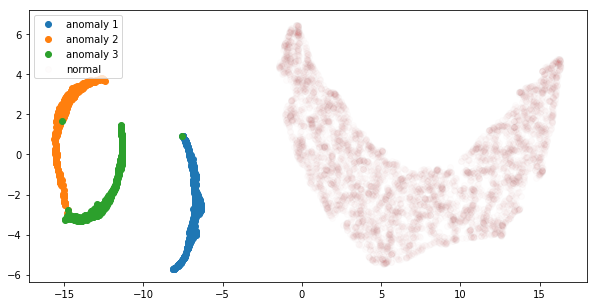

DBSCAN clustering


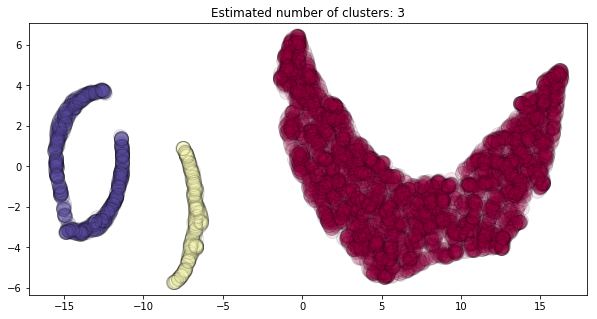

F-measure: 1.0
hashtag count dist


cluster coef dist


log degree coef dist


network topology
======== cluster #0
density: 0.002804438522310222
avg clustering: 0.002753647368320839
======== cluster #1
density: 0.09963273453093813
avg clustering: 0.09998444438629447
======== cluster #2
density: 0.0513238689591395
avg clustering: 0.09497007305276577


In [38]:
############################ embedding #####################################
print('visualize embedding')
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for ind, b in enumerate(blocks):
    s = b['idx_range'][0]
    e = b['idx_range'][1]
    ax.scatter(X_embedded[list(range(s,e)),0], 
               X_embedded[list(range(s,e)),1],label='anomaly '+str(ind + 1))

temp_aggregate = []
for i in idx_list:
    if i not in tracking_artificial_anomaly_aggregate:
        temp_aggregate.append(i)
        
ax.scatter(X_embedded[temp_aggregate,0], 
    X_embedded[temp_aggregate,1],label='normal',alpha=.01)

plt.legend(loc=2)
plt.show()

############################ clsutering #####################################
print('DBSCAN clustering')
X = X_embedded
labels_true = tracking_artificial_anomaly
db = DBSCAN(eps=1, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_embedded[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14, alpha=.1)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, alpha=.01)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

############################ anomaly metric #####################################################

anomaly_idx = [0] * input_size
for l in unique_labels:
    cluster_idx = np.argwhere(labels == l).reshape(-1)
    cluster_ajac = ajacency[cluster_idx,:][:,cluster_idx]
    cluster_ajac_density = nx.density(nx.from_numpy_array(cluster_ajac,create_using=nx.DiGraph))
    if cluster_ajac_density >= density_threshold:
        for i in cluster_idx:
            anomaly_idx[i] = 1
fmeasure = f1_score(tracking_is_anomaly,anomaly_idx,average='macro')
print("F-measure: {}".format(fmeasure))
fmeasure_list.append(fmeasure)

############################ hashtag dist for small cluster #####################################
print('hashtag count dist')

data_temp = []

for l in unique_labels:
    cluster_idx = np.argwhere(labels == l).reshape(-1)
    if len(cluster_idx) < small_cluster_threshold:
        cluster_attribute = attribute[cluster_idx,:][:,hashtag_visual_idx]
        cluster_attribute_dist = (np.sum(cluster_attribute, axis=0) + 1) / (np.sum(cluster_attribute) + 1 * len(hashtag_visual_idx))

        trace = go.Scatter(
            x = list(range(len(hashtag_visual_idx))),
            y = cluster_attribute_dist,
            mode = 'lines',
            name = 'cluster #{}'.format(l),
            line = dict(
                color = matplotlib.colors.rgb2hex(colors[l])
            )
        )
        
        data_temp.append(trace)

layout = go.Layout(
    width=1000,
    height=500,
    xaxis = go.layout.XAxis(
        tickmode = 'array',
        tickvals = list(range(len(hashtag_visual_idx))),
        ticktext = [attribute_names[i] for i in hashtag_visual_idx],
        tickangle = -90,
        automargin=True
    )
)

fig = go.Figure(
    data = data_temp,
    layout = layout
)


iplot(fig)

############################ clustering coef dist for small cluster #####################################
print('cluster coef dist')

hist_data_temp = []
group_labels_temp = []
colors_temp = []

for l in unique_labels:
    cluster_idx = np.argwhere(labels == l).reshape(-1)
    if len(cluster_idx) < small_cluster_threshold:
        cluster_ajacency = ajacency[cluster_idx,:][:,cluster_idx]
        G_temp = nx.from_numpy_matrix(cluster_ajacency,create_using=nx.DiGraph)
        clustering_coef = list(nx.clustering(G_temp).values())
        hist_data_temp.append(clustering_coef)
        group_labels_temp.append('cluster #{}'.format(l))
        colors_temp.append( matplotlib.colors.rgb2hex(colors[l]))
        
fig = ff.create_distplot(hist_data_temp, group_labels_temp, show_rug=False, show_hist=False, curve_type='normal', 
                         colors=colors_temp)        
iplot(fig)

############################ degree coef dist for small cluster #####################################
print('log degree coef dist')

hist_data_temp = []
group_labels_temp = []
colors_temp = []

for l in unique_labels:
    cluster_idx = np.argwhere(labels == l).reshape(-1)
    if len(cluster_idx) < small_cluster_threshold:
        cluster_ajacency = ajacency[cluster_idx,:][:,cluster_idx]
        G_temp = nx.from_numpy_matrix(cluster_ajacency,create_using=nx.DiGraph)
        degree_sequence = [np.log(d+1) for n, d in G_temp.degree()]
        hist_data_temp.append(degree_sequence)
        group_labels_temp.append('cluster #{}'.format(l))
        colors_temp.append( matplotlib.colors.rgb2hex(colors[l]))
        
fig = ff.create_distplot(hist_data_temp, group_labels_temp, show_rug=False, show_hist=False, curve_type='normal', 
                         colors=colors_temp)        
iplot(fig)

############################ network topology for small cluster #####################################
print('network topology')
temp_offset = 0
for l in unique_labels:
    # get cluster idx
    cluster_idx = np.argwhere(labels == l).reshape(-1)

    if len(cluster_idx) < small_cluster_threshold:
        print('======== cluster #{}'.format(l))
        # get cluster ajacency and add attributes
        cluster_ajacency = ajacency[cluster_idx,:][:,cluster_idx]
        G_temp = nx.from_numpy_matrix(cluster_ajacency,create_using=nx.DiGraph)
        attrs = {}
        for ind, i in enumerate(cluster_idx):
            attrs[ind] = {}
            attrs[ind]['hashtags'] = '_'.join(sorted([attribute_names[j] for j in np.argwhere(attribute[i]==1).reshape(-1) if j in hashtag_visual_idx]))
            attrs[ind]['username'] = str(user_names[i])
            
        nx.set_node_attributes(G_temp, attrs)

        # save graph
#         nx.write_graphml(G_temp, "results/run#{}-cluster#{}.graphml".format(run_ind, l))
        
        # calculate stats
        print('density: {}'.format(nx.density(G_temp)))
        print('avg clustering: {}'.format(nx.average_clustering(G_temp)))